# PlotResults.ipynb
### example notebook demonstrating how to plot and inspect simulation outputs

In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

In [2]:
from MADLens.util import *

### list all possible run files

In [3]:
run_dir   = '../runs'

githashes = os.listdir(run_dir)
for githash in githashes:
    print(githash)
    path = os.path.join(run_dir,githash)
    print(os.listdir(path))

2120673
['small_run.json', 'test_run_20.json', 'small_run_0.json', 'test_run_40.json', 'test_run_00.json', 'small_run_10.json', 'small_run_00.json', 'test_run_30.json', 'test_run_10.json']
c0f314b
['deriv_run0.json']
b2f7b0b
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
cd8f0a9
['med_res0.json', 'small_res0.json']
eba3a69
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
9481ab1
['small_run.json']
e6fc19b
['transfer_test0.json']
6a89a8b
['deriv_run0.json']
912403a
['deriv_run0.json']
de321bb
['small_run.json']
53bbbde
['deriv_run0.json']
58fb8b3
['small_run.json']
5d6669a
['transfer_test0.json']
eb13929
['transfer_test0.json']
43458b5
['small_run.json']
106b3db
['small_run.json']
f05cdbe
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
dc2637e
['transfer_test0.json']
bd480a3
['deriv_run0.json']
245c7de
['transfer_test0.json']
ec86

In [4]:
z1_runs={}

In [97]:
z1_runs['512']={}
z1_runs['256']={}


### choose a run and load results into memory

In [98]:
run = Run(githash='bc0059d', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['256']['interp']=run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 1.00, PGD True and interpolation True.


In [104]:
run = Run(githash='dc2637e', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['']['no_interp'] = run

Loading run with BoxSize 256, Resolution 1024, SourceRedshift 1.00, PGD False and interpolation False.


FileNotFoundError: [Errno 2] No such file or directory: '/global/u2/v/vboehm/codes/MADLens/results/dc2637e/transfer_test0/maps/map_decon_zsource10_map0_of5.npy'

In [7]:
# load a single map kappa map at a specific source redhsift into memory
mymap = z1_runs['256'].get_map(z_source=z1_runs['256'].params['zs_source'][0],num=0)

### plot results

In [9]:
L, clkk, N = get_2Dpower(down_sampled_map)


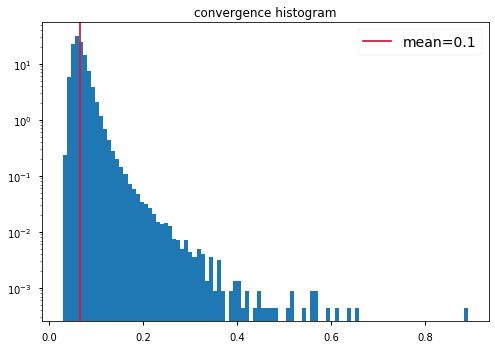

In [92]:
plt.figure()
plt.title('convergence histogram')
#_ = plt.hist(mymap.value.flatten(),bins=100,density=True, log=True)
_ = plt.hist(down_sampled_map.value.flatten(),bins=100,density=True, log=True)
mean = np.mean(mymap)
plt.axvline(x=mean,color='crimson', label='mean=%.1f'%mean)
plt.legend(fontsize=14)
plt.show()

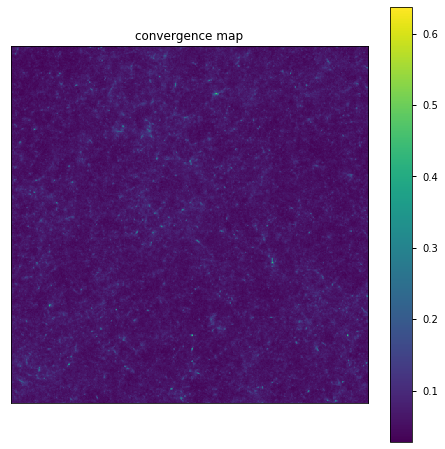

In [93]:
down_sampled_map = downsample_map(mymap,512,z1_runs['256'].params)
plt.figure(figsize=(8,8))
plt.title('convergence map')
plt.imshow(np.log(down_sampled_map+1),cmap='viridis')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.colorbar()
plt.show()

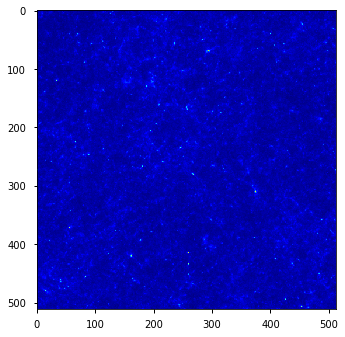

In [90]:
plt.imshow(down_sampled_map,cmap='jet')

<Figure size 360x288 with 0 Axes>

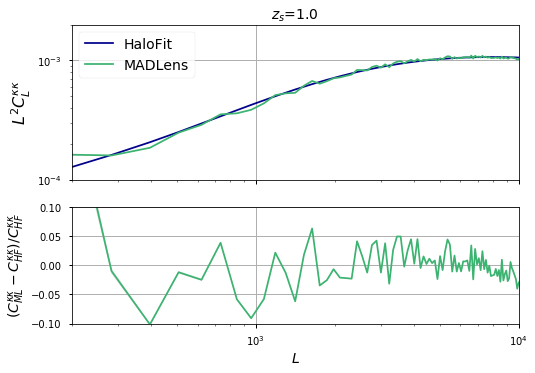

In [101]:

ll   = len(z1_runs['256']['interp'].params['zs_source'])

plt.figure(figsize=(ll*5,4))
for ii, zs in enumerate(z1_runs['256']['interp'].params['zs_source']):
    
    x    = z1_runs['256']['interp'].measured_cls[str(zs)]['L']
    y    = z1_runs['256']['interp'].measured_cls[str(zs)]['clkk']
    yerr = z1_runs['256']['interp'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp'].measured_cls[str(zs)]['N']
    yt   = z1_runs['256']['interp'].theory_cls[str(zs)]['clkk']
    
    ratio = (y-yt)/yt
    ratio_error = (yerr)/yt 
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
    ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
    ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
    ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
    ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
    ax[0].grid()
    
    ax[1].semilogx(x,ratio, color='mediumseagreen')
    ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
    ax[1].grid()
    ax[1].set_ylim(-0.1,0.1)
    ax[1].set_ylabel('relative difference')
    ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
    ax[1].set_xlabel('$L$',fontsize=14)
    ax[0].set_xlim(200,10000)
    ax[0].set_ylim(1e-4,2e-3)

<Figure size 360x288 with 0 Axes>

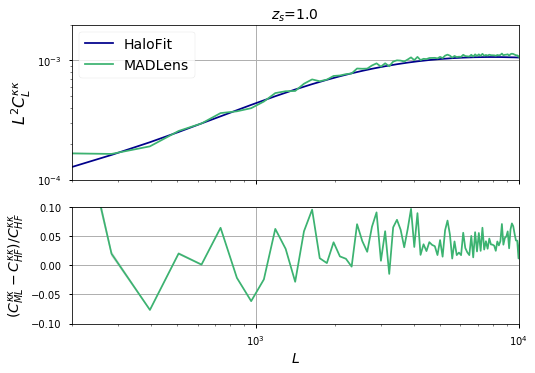

In [103]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['no_interp'].params['zs_source'])

plt.figure(figsize=(ll*5,4))
for ii, zs in enumerate(z1_runs['256']['no_interp'].params['zs_source']):
    
    x    = z1_runs['256']['no_interp'].measured_cls[str(zs)]['L']
    y    = z1_runs['256']['no_interp'].measured_cls[str(zs)]['clkk']
    yerr = z1_runs['256']['no_interp'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['no_interp'].measured_cls[str(zs)]['N']
    yt   = z1_runs['256']['no_interp'].theory_cls[str(zs)]['clkk']
    
    ratio = (y-yt)/yt
    ratio_error = (yerr)/yt 
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
    ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
    ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
    ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
    ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
    ax[0].grid()
    
    ax[1].semilogx(x,ratio, color='mediumseagreen')
    ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
    ax[1].grid()
    ax[1].set_ylim(-0.1,0.1)
    ax[1].set_ylabel('relative difference')
    ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
    ax[1].set_xlabel('$L$',fontsize=14)
    ax[0].set_xlim(200,10000)
    ax[0].set_ylim(1e-4,2e-3)